# Simulating Colony Barcode Counts

Given a number of spatial locations for beads and bacterial colonies, we want to generate a bacterial barcodes count matrix for the beads. The barcode counts going to each bead are assigned according to a Gaussian kernel.

In [1]:
import numpy as np
import pandas as pd
import gc
import anndata
import math
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity

import sys
sys.path.append("../functions/")
import simulate_barcodes_sampling
import simulate
import utils
import plots

In [2]:
DATA_PATH = '../../data/'

In [3]:
# Define parameters for the run
SEED = 42 # Random seed for reproducibility
RNG = np.random.default_rng(SEED)
NUM_PROC = 16

BEADS_PER_CM2 = 10**6
COLONIES_PER_CM2 = 250000
SIGMA_PIX = 5   # 3: 1113 rpb
AREA_CM2 = 0.01

BEADS = int(BEADS_PER_CM2 * AREA_CM2)
COLONIES = int(COLONIES_PER_CM2 * AREA_CM2)
SAVING = False

# Factor by which colonies should extended past beads, this reduces edge effects where beads along the
# edge get fewer reads
COLONY_EXT = 0.05

BARCODE_OVERLAP = True
OVERLAP_COMPLEXITY = 10**8

SUBSAMPLE_READS = True
READS_PER_BEAD = 100 # Average number of reads per bead for the read sub-sampling
n = np.floor(np.sqrt(BEADS))
SIGMA = SIGMA_PIX/n  # Standard deviation for the Gaussian modelling diffusion around a colony

# Generate random colonies on a unit square and beads on a grid
y,x = np.meshgrid(np.arange(0,n), np.arange(0,n))
y = y.flatten()
x = x.flatten()
beads_coords = np.array([x/max(x), y/max(y)]).T
colonies_coords = RNG.random((int((COLONIES)*((1+2*COLONY_EXT)**2)), 2))*(1 + 2*COLONY_EXT) - COLONY_EXT

In [4]:
if SAVING:
    np.savetxt(DATA_PATH + 'spatial-coordinates/%sB.tsv'%utils.human_format(BEADS), BEADS, delimiter='\t')
    np.savetxt(DATA_PATH + 'spatial-coordinates/%sC.tsv'%utils.human_format(COLONIES), COLONIES, delimiter='\t')

In [5]:
beads_df = pd.DataFrame(data=beads_coords, columns=['x', 'y'])
colonies_df = pd.DataFrame(data=colonies_coords, columns=['x', 'y'])

In [6]:
# Shows one of the point cloud dfs (beads or colonies)
def show_points(points_df, title, n_points=10000):
    # Determine how many points we are plotting
    n_points = np.min([n_points, points_df.shape[0]])
    
    plt.figure(figsize=(10, 10))
    plt.title(title)
    
    inds = list(points_df.index.copy())
    np.random.shuffle(inds)
    inds_to_plot = inds[:n_points]
    plt.scatter(points_df.loc[inds_to_plot, 'x'], points_df.loc[inds_to_plot, 'y'])

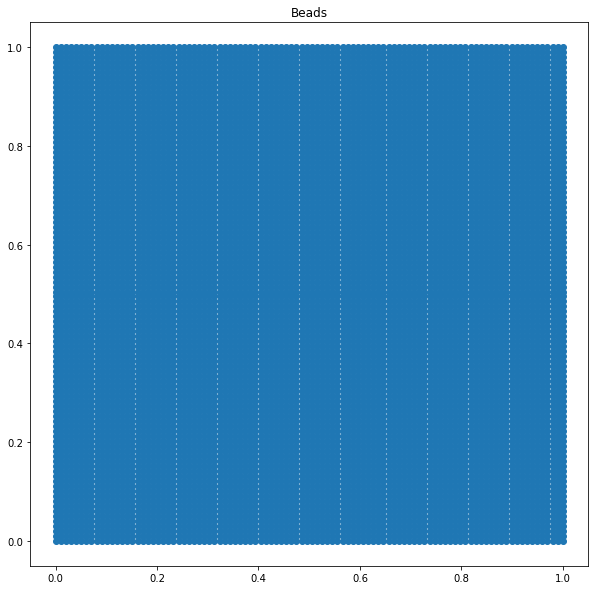

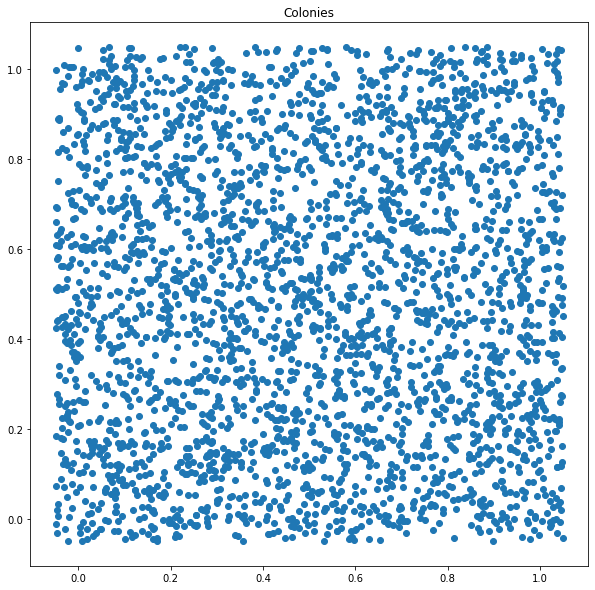

In [7]:
show_points(beads_df, 'Beads')
show_points(colonies_df, 'Colonies')

### Read Data and Setup Params

In [8]:
M = colonies_df.shape[0]

SAVE_PATH = DATA_PATH + 'adata/BC_distances_%sB_%sC_sigma%g_cols_%s'%(utils.human_format(BEADS),
                                                              utils.human_format(COLONIES),
                                                              SIGMA_PIX,
                                                              utils.human_format(OVERLAP_COMPLEXITY))
if not BARCODE_OVERLAP: SAVE_PATH += "_no-overlap"
if not SUBSAMPLE_READS: SAVE_PATH += "_no-read-subsampling"
SAVE_PATH += "_patches"
SAVE_PATH += ".h5ad"

### Convert coordinates to counts with noise

First, we want to convert bead and colony coordinates to counts by applying a gaussian function on distance. Then, we want to add some normally distributed noise to the barcode counts.

In [9]:
# Load the bead read distribution and plot a histogram and check what the mean number rpb
read_dist = np.load('../../data/experimental-data/reads_typed.npy')
mean_rpb = np.mean(read_dist)
mean_rpb

227.1601688456352

In [10]:
# Plot a histogram of rpb
read_hist = np.histogram(read_dist, bins=np.arange(np.min(read_dist), np.max(read_dist) + 1, 1))
read_counts = read_hist[1][:-1]
read_probs = read_hist[0]/np.sum(read_hist[0])

In [11]:
print("Build the read count matrix...")
overlaps = pd.read_csv('../../data/experimental-data/pam_barcode_cnt.tsv', sep='\t', index_col=0)
total_counts = overlaps['Count'].sum()
overlaps['Dist'] = overlaps['Count']/total_counts

reads_dist = pd.DataFrame()
reads_dist['reads'] = read_counts.astype(int)
reads_dist['p'] = read_probs

colony_counts = simulate_barcodes_sampling.get_colony_counts(SIGMA, beads_coords, colonies_coords, 
                                                            num_proc=NUM_PROC,
                                                            overlap_dist=overlaps['Dist'], 
                                                            reads_dist=reads_dist, rpb=READS_PER_BEAD,
                                                            chunksize=3000,
                                                            scaling=True,
                                                            overlap_scaling=True,
                                                            overlap_complexity=OVERLAP_COMPLEXITY)

Build the read count matrix...


100%|██████████| 10000/10000 [00:02<00:00, 4039.39it/s]


Matrix build time: 2.769192934036255


In [12]:
# Remove empty colonies
row_sum = colony_counts.sum(axis=0)
nz = np.array(row_sum > 0).flatten()
colony_counts = colony_counts[:, nz]

In [13]:
# Make adata
adata = anndata.AnnData(X=colony_counts, obs=beads_df, var=pd.DataFrame(index=range(colony_counts.shape[1])), dtype=np.int16)
adata.obs['spatial_color'] = simulate.euclidean_color(adata.obs.x, adata.obs.y)

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
SAVE_PATH

'../../data/adata/BC_distances_10kB_2.5kC_sigma5_cols_100M_patches.h5ad'

In [15]:
adata.write_h5ad(SAVE_PATH)

## Check the Quality of our Counts

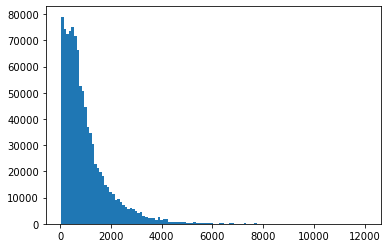

In [14]:
# Check the distribution is reasonable
counts = np.array(colony_counts.sum(axis=1))
a = plt.hist(counts, bins=np.arange(min(counts), max(counts +1), 100))
plt.show()

In [18]:
# Make adata
adata = anndata.AnnData(X=colony_counts, obs=beads_df, var=pd.DataFrame(index=range(colony_counts.shape[1])), dtype=np.int16)
adata.obs['spatial_color'] = simulate.euclidean_color(adata.obs.x, adata.obs.y)

In [23]:
adata.X

<1000000x10000000 sparse matrix of type '<class 'numpy.int16'>'
	with 322867208 stored elements in Compressed Sparse Row format>

In [24]:
# Row normalize the data
adata_norm = adata.copy()

In [25]:
adata_norm.X = normalize(adata_norm.X, norm='l1', axis=1)

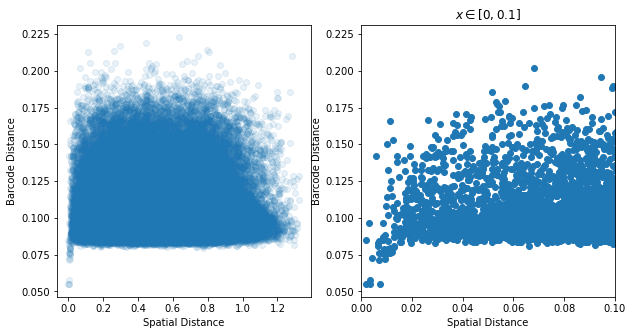

In [26]:
# Look at pairwise distances
x = plots.plot_pairwise_distances(adata_norm, 0.1, n_comps=10**5)

In [27]:
# Calculate the Euclidean distance between two dense vectors
def euclidean_dist (x,y):
    return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

In [28]:
def calculate_dists(adata, n_comps=10**4):
    beads = np.array([adata.obs.x, adata.obs.y]).T
    dists = np.zeros((n_comps, 2))
    for m in range(n_comps):
        i = np.random.randint(low=0, high=adata.shape[0])
        j = np.random.randint(low=0, high=adata.shape[0])
        dists[m, :] = [1 - cosine_similarity(adata.X[i,:], adata.X[j,:]),
                       euclidean_dist(beads[i,:], beads[j,:])]
    return dists

In [29]:
dists = calculate_dists(adata, n_comps=10**5)

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  


KeyboardInterrupt: 

In [ ]:
thresh = 0.1
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.scatter(dists[:,1], dists[:,0], alpha=0.1, rasterized=True)
plt.xlabel('Spatial Distance')
plt.ylabel('Barcode Distance')

plt.subplot(1, 2, 2)
plt.scatter(dists[:,1], dists[:,0], alpha=1, rasterized=True)
plt.xlabel('Spatial Distance')
plt.ylabel('Barcode Distance')
plt.xlim([0, thresh])
plt.title("$x \in [0, {}]$".format(thresh))
plt.show()

In [31]:
adata.write_h5ad(SAVE_PATH)

... storing 'spatial_color' as categorical
